In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import scipy.io.wavfile
import scipy.signal
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.utils import shuffle
import os
import subprocess
import platform
from scipy.signal import butter, filtfilt

In [3]:
#Creating the data frame

# Input the folder name
folder_name = input("Please enter the subject name: ")

# Define the column names
column_names = ['FZ', 'FC1', 'FC2', 'C3', 'CZ', 'C4', 'CPZ', 'PZ', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']

# Create an empty DataFrame 
df = []
# Check if the folder exists
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    # Iterate through the files in the folder
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            # Read the CSV file
            file_path = os.path.join(folder_name, file_name)
            print('file_path',file_path)
            df_temp = pd.read_csv(file_path)

            # Print the file name and the shape of the read data
            print(f"Processing {file_name}: {df_temp.shape}")

            # Append the data to the main DataFrame
            df.append(df_temp)
            
    combined_data_array_3d = np.array(df)
    combined_data_array_2d= combined_data_array_3d.reshape(8 * 9999, 21)
    # Print the final DataFrame shape
    print(f"Final DataFrame shape: {combined_data_array_2d.shape}")
    
# Convert the NumPy array to a pandas DataFrame
Combined_raw_eeg = pd.DataFrame(combined_data_array_2d)
Combined_raw_eeg.columns = column_names

#Excluding the useless columns
columns_to_remove = ['AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'Battery', 'Sample', 'Unknown','Female/Male', 'Outdoor/Indoor', 'Human Behavior']
Combined_raw_eeg = Combined_raw_eeg.drop(columns=columns_to_remove, axis=1)
# print('Combined_raw_eeg_excluded_shape',Combined_raw_eeg.shape)

# Save the DataFrame to an Excel file
output_file_name = "Combined_raw_eeg_excluded.xlsx"
output_file_path = os.path.join(folder_name, output_file_name)
Combined_raw_eeg.to_excel(output_file_path, index=False)
   
 
# Open the folder using the default file explorer
if platform.system() == "Windows":
        subprocess.run(["explorer", folder_name])
elif platform.system() == "Darwin":  # macOS
        subprocess.run(["open", folder_name])
elif platform.system() == "Linux":
        subprocess.run(["xdg-open", folder_name])
else:
        print("Unsupported platform.")


file_path Behroz Khalil Loo\raw_eeg_data_1.csv
Processing raw_eeg_data_1.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_2.csv
Processing raw_eeg_data_2.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_3.csv
Processing raw_eeg_data_3.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_4.csv
Processing raw_eeg_data_4.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_5.csv
Processing raw_eeg_data_5.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_6.csv
Processing raw_eeg_data_6.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_7.csv
Processing raw_eeg_data_7.csv: (9999, 21)
file_path Behroz Khalil Loo\raw_eeg_data_8.csv
Processing raw_eeg_data_8.csv: (9999, 21)
Final DataFrame shape: (79992, 21)


In [4]:
#Event
# Create a new column 'event'
Combined_raw_eeg['event'] = ''

# Iterate over the rows and assign values to the 'event' column based on the 'Instruction' column
for index, row in Combined_raw_eeg.iterrows():
    if row['Instruction'] == 'F' or row['Instruction'] == 'M':
        Combined_raw_eeg.at[index, 'event'] = 'F'
    elif row['Instruction'] == 'I' or row['Instruction'] == 'O':
        Combined_raw_eeg.at[index, 'event'] = 'S'
print('Combined_raw_eeg_event_included_shape',Combined_raw_eeg.shape)

# # Save the DataFrame to an Excel file
output_file_name = "Combined_raw_eeg_excluded.xlsx"
output_file_path = os.path.join(folder_name, output_file_name)
Combined_raw_eeg.to_excel(output_file_path, index=False)

# Select useful columns
eeg_df_raw = Combined_raw_eeg[['FZ', 'FC1', 'FC2', 'C3', 'CZ', 'C4', 'CPZ', 'PZ']]
print('eeg_df_shape' ,eeg_df_raw.shape)


# Use for bandpass
eeg_df_bandpass= Combined_raw_eeg[['FZ', 'FC1', 'FC2', 'C3', 'CZ', 'C4', 'CPZ', 'PZ']]
print('eeg_df_bandpass_shape' ,eeg_df_bandpass.shape)

Combined_raw_eeg_event_included_shape (79992, 10)
eeg_df_shape (79992, 8)
eeg_df_bandpass_shape (79992, 8)


In [5]:
#Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

for column in eeg_df_raw.columns:
    eeg_df_bandpass.loc[:, column] = butter_bandpass_filter(eeg_df_bandpass[column], lowcut=.1, highcut=30, fs=250)
      
print('eeg_df_band_pass', eeg_df_bandpass.shape)

eeg_df_band_pass (79992, 8)


In [6]:
#Pre-proccessing

# Denoising 
def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        # Convert column to numeric format
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce')
        # Select only numeric columns
        X = df_denoised.select_dtypes(include=['float64', 'int64'])
        # Fit KNeighborsRegressor
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform')
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        # Predict values
        y_pred = clf.predict(X.index.values[:, np.newaxis])  
        df_denoised[col_name] = y_pred
        
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()

    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended

    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

In [7]:
# This cell is used for applying the preprocessing functions and concatinating the dataframes 
eeg_df_denoised = preprocess(eeg_df_bandpass, col_names=list(eeg_df_bandpass.columns), n_clusters=[50]*len(eeg_df_bandpass.columns))
print('eeg_df_denoised', eeg_df_denoised.shape)

# Concatenate the denoised dataframe with the original dataframe, including the 'event' column
eeg_df_denoised_with_event = pd.concat([eeg_df_denoised, Combined_raw_eeg['event']], axis=1)

# Save the DataFrame to an Excel file
output_file_name = "Denoised_eeg_event_included.xlsx"
output_file_path = os.path.join(folder_name, output_file_name)
eeg_df_denoised_with_event.to_excel(output_file_path, index=False)

# Remove Nan rows
eeg_df_denoised_with_event = eeg_df_denoised_with_event.dropna(axis=0)
print(eeg_df_denoised_with_event.shape)

eeg_df_denoised (79992, 8)
(79992, 9)


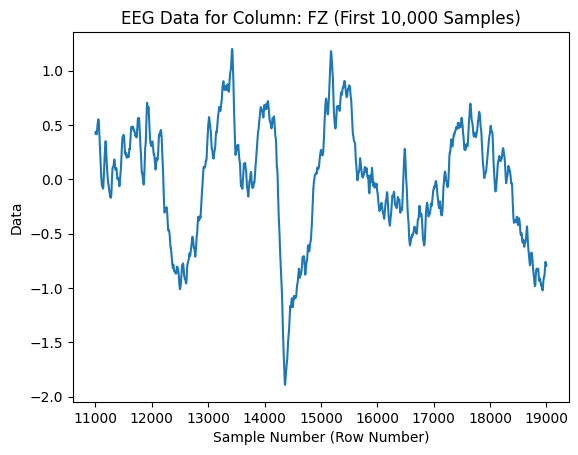

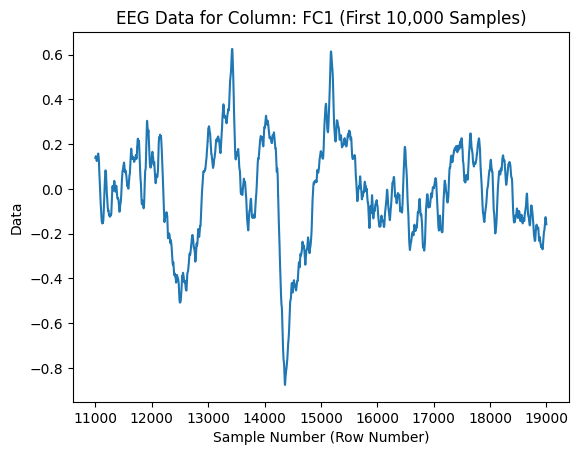

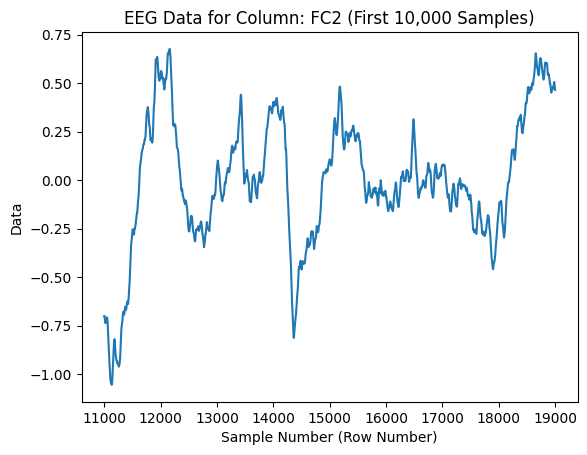

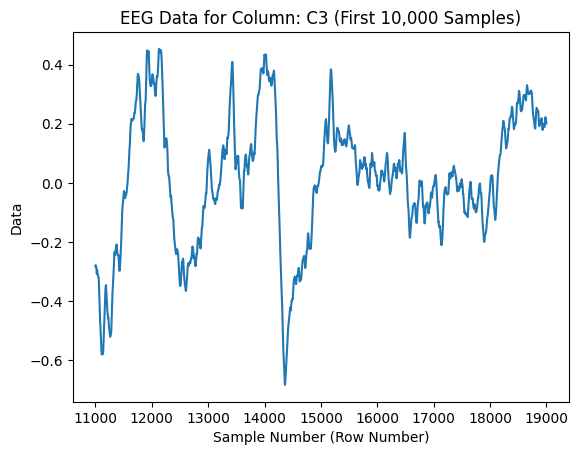

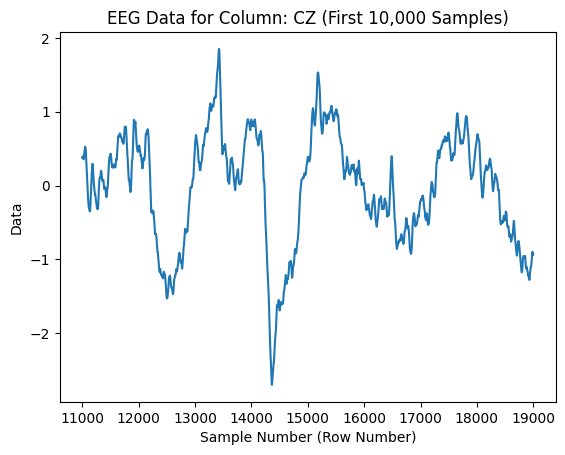

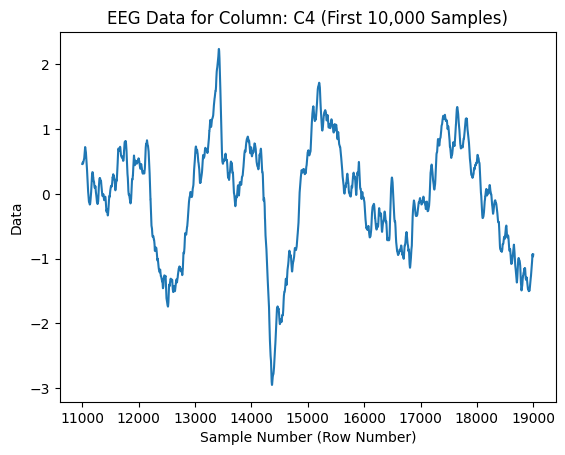

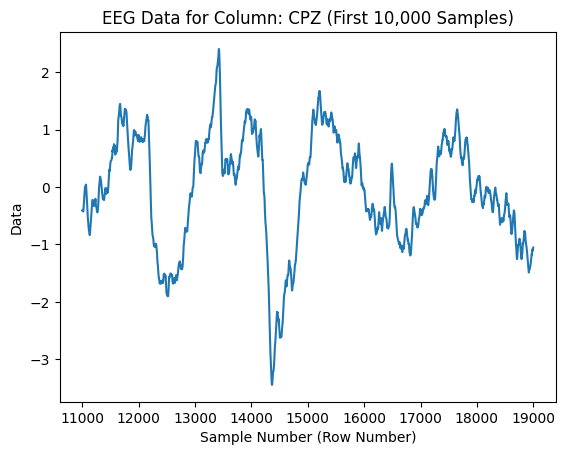

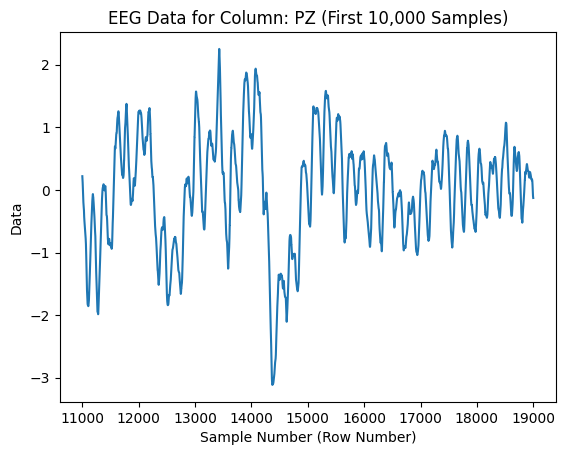

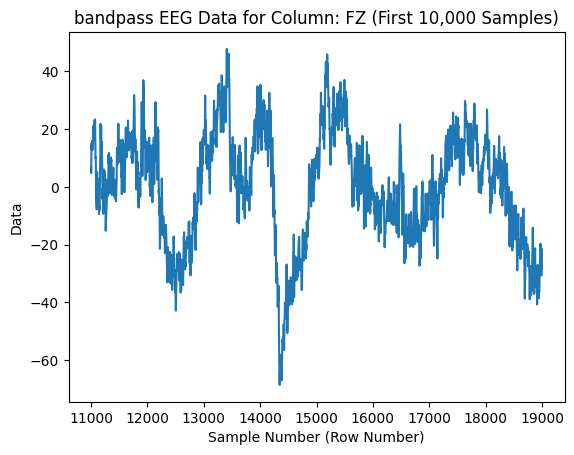

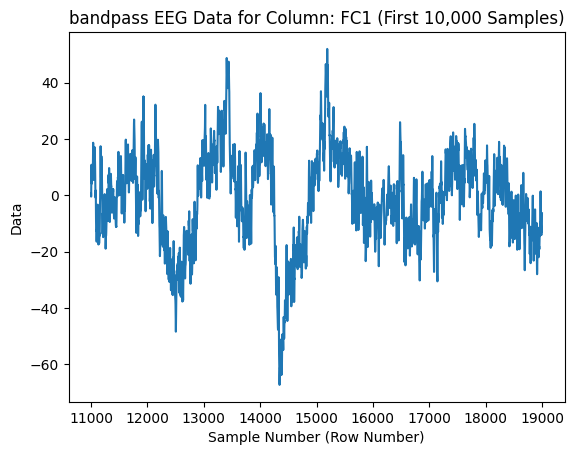

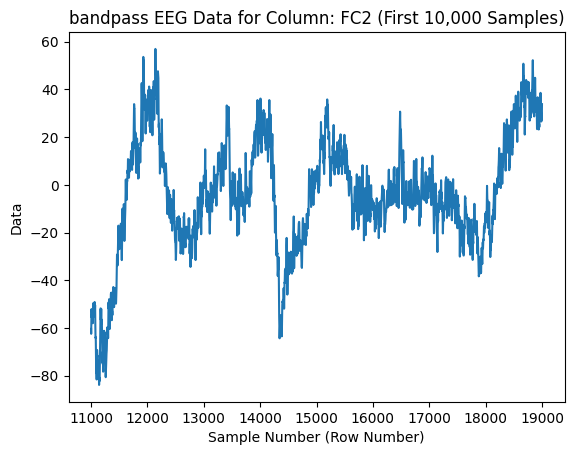

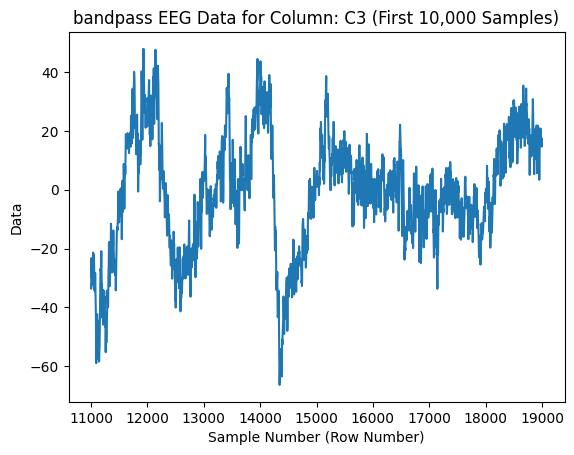

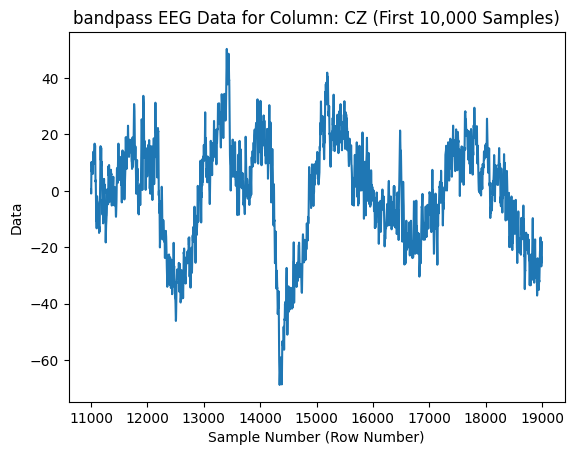

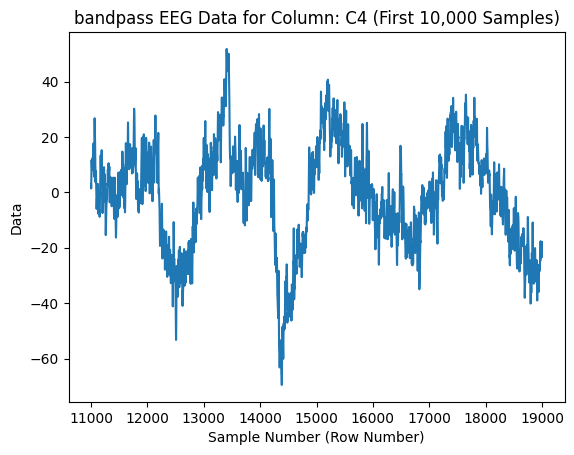

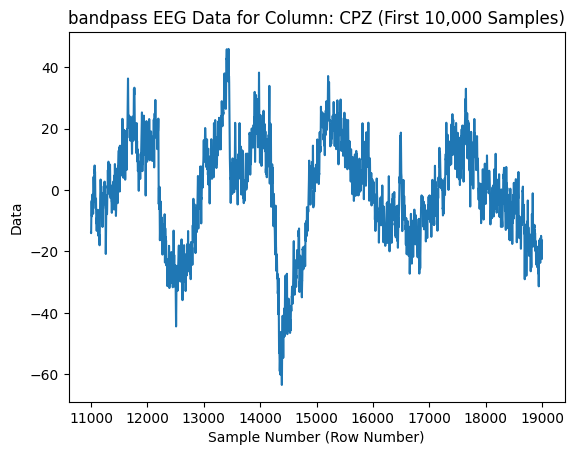

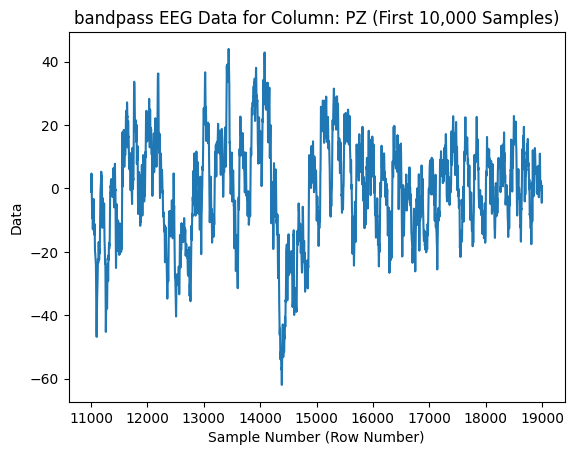

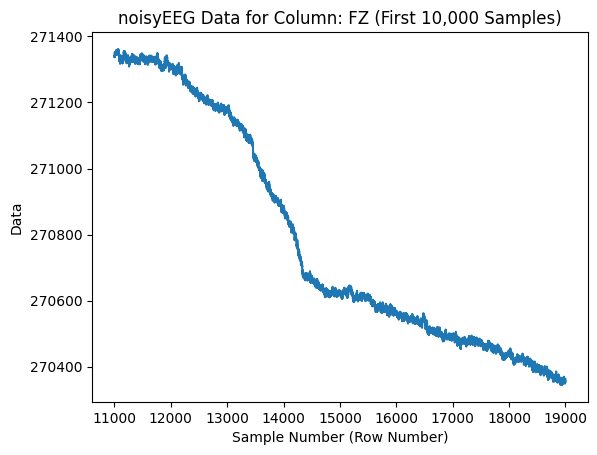

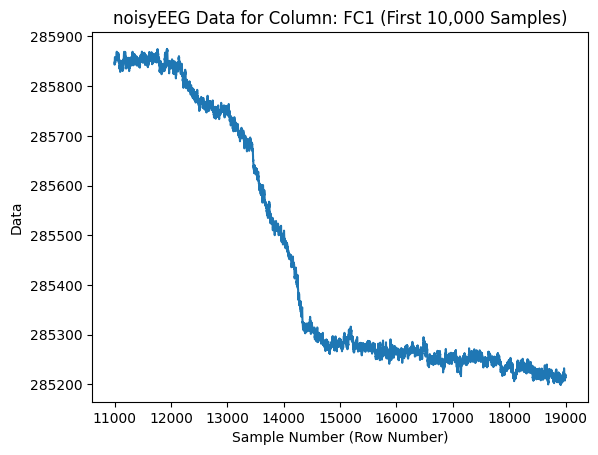

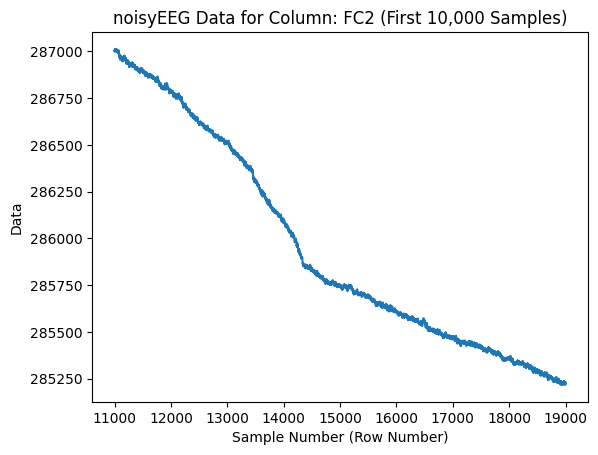

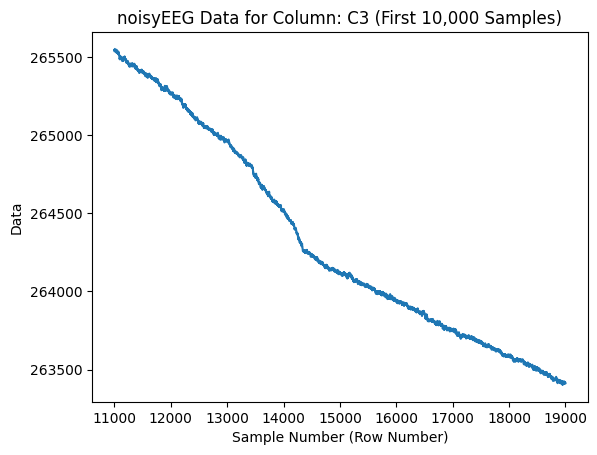

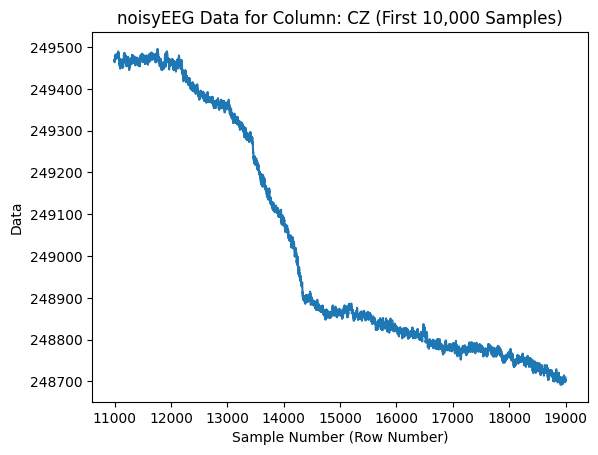

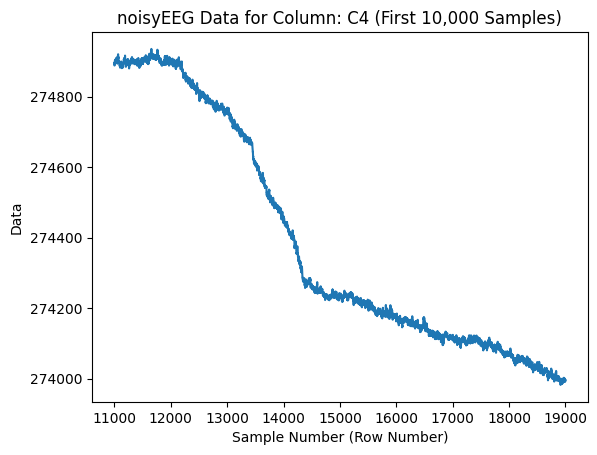

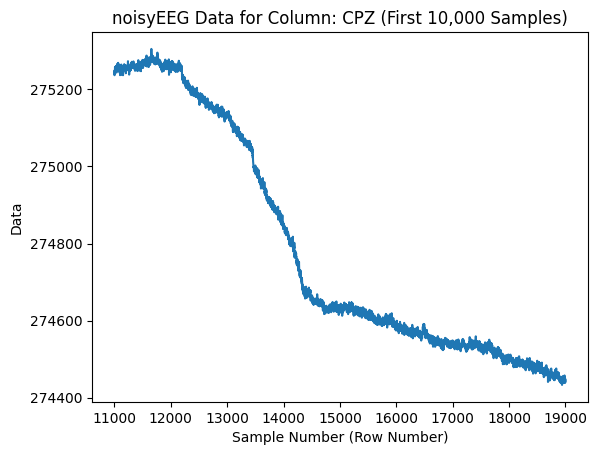

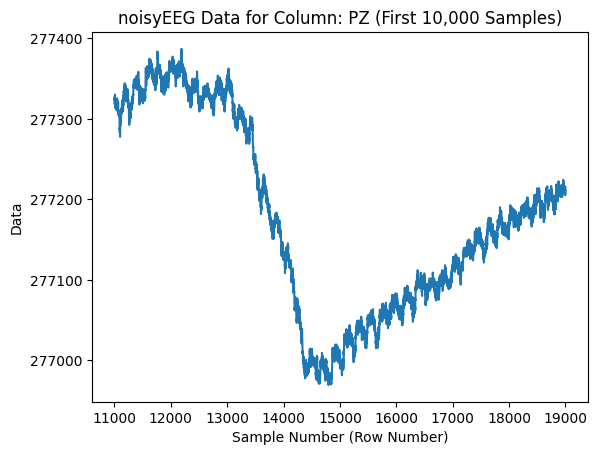

In [8]:
# Select first 10,000 samples
eeg_df_denoised_samples = eeg_df_denoised.iloc[11000:19000]
eeg_df_raw_samples = eeg_df_raw.iloc[11000:19000]
eg_df_bandpass_samples = eeg_df_bandpass.iloc[11000:19000]


# Plot each column separately for the first 10,000 samples
for column in eeg_df_denoised_samples.columns:
    plt.figure()  # Create a new figure for each column
    plt.plot(eeg_df_denoised_samples.index, eeg_df_denoised_samples[column])
    plt.xlabel('Sample Number (Row Number)')
    plt.ylabel('Data')
    plt.title(f'EEG Data for Column: {column} (First 10,000 Samples)')
    plt.show()

# Plot each column separately for the first 10,000 samples
for column in eg_df_bandpass_samples.columns:
    plt.figure()  # Create a new figure for each column
    plt.plot(eg_df_bandpass_samples.index, eg_df_bandpass_samples[column])
    plt.xlabel('Sample Number (Row Number)')
    plt.ylabel('Data')
    plt.title(f'bandpass EEG Data for Column: {column} (First 10,000 Samples)')
    plt.show()


for column in eeg_df_raw_samples.columns:
    plt.figure()  # Create a new figure for each column
    plt.plot(eeg_df_raw_samples.index, eeg_df_raw_samples[column])
    plt.xlabel('Sample Number (Row Number)')
    plt.ylabel('Data')
    plt.title(f'noisyEEG Data for Column: {column} (First 10,000 Samples)')
    plt.show()


In [28]:
#add the instruction and image lable and remove unrelated images
# Map column names to their respective indices
column_indices = {'Instruction': 17, 'Female/Male': 18, 'Outdoor/Indoor': 19}

# Select the desired columns using integer indices
selected_columns = [column_indices['Instruction'], column_indices['Female/Male'], column_indices['Outdoor/Indoor']]
data_im_ins = combined_data_array_2d[:, selected_columns]

# Print the shape of the denoised_im_ins array
print(data_im_ins.shape)

denoised_im_ins = np.concatenate((eeg_df_denoised, data_im_ins), axis=1)
print(denoised_im_ins.shape)

# Check the third last column (column 9) and keep rows if column 9 is equal to 1
filtered_denoised_im_ins = denoised_im_ins[(denoised_im_ins[:, -3] == denoised_im_ins[:, -2]) | (denoised_im_ins[:, -3] == denoised_im_ins[:, -1])]

# Print the filtered array and its shape
print(filtered_denoised_im_ins.shape)

# Convert the NumPy array to a DataFrame
filtered_denoised_im_ins_df = pd.DataFrame(filtered_denoised_im_ins)

# Create a new column 'event'
filtered_denoised_im_ins_df['event'] = ''

# Iterate over the rows and assign values to the 'event' column based on the 'Instruction' column
for index, row in filtered_denoised_im_ins_df.iterrows():
    if row.iloc[-4] == 'F' or row.iloc[-4] == 'M':
        filtered_denoised_im_ins_df.at[index, 'event'] = 'F'
    elif row.iloc[-4] == 'I' or row.iloc[-4] == 'O':
        filtered_denoised_im_ins_df.at[index, 'event'] = 'S'

print('Combined_raw_eeg_event_included_shape', filtered_denoised_im_ins_df.shape)

# Select the first eight columns and the 'event' column
selected_data = filtered_denoised_im_ins_df.iloc[:, :8].join(filtered_denoised_im_ins_df['event'])

# Print the selected data and its shape
print(selected_data)
print('Selected_data_shape', selected_data.shape)

(79992, 3)
(79992, 11)
(71994, 11)
Combined_raw_eeg_event_included_shape (71994, 12)
              0         1         2         3         4         5         6   
0      0.203974  0.134354  0.128442  0.153267  0.238221  0.406793  0.895354  \
1      0.206022  0.136017  0.126173  0.149888  0.241784  0.402118  0.900066   
2      0.208207  0.137853  0.123905  0.146881  0.245052  0.396859  0.902536   
3      0.209518  0.139474   0.12114  0.144012  0.246535  0.389423  0.899894   
4      0.209328  0.140647  0.117587   0.14107  0.245422  0.379027   0.89075   
...         ...       ...       ...       ...       ...       ...       ...   
71989   0.20194  0.008378   0.06119  0.049683  0.299049  0.211572   1.02531   
71990   0.20194  0.008378  0.061188  0.049683  0.299049  0.211573  1.025311   
71991   0.20194  0.008378  0.061187  0.049683  0.299048  0.211574  1.025312   
71992   0.20194  0.008377  0.061185  0.049683  0.299048  0.211574  1.025314   
71993   0.20194  0.008377  0.061184  0.049683 

In [29]:
# For calculating the window size for each event, 
# You can use the shift method and boolean indexing to find the row indexes where a specific column value changes in a Pandas DataFrame. 
# So I found that every 9000 samples the events column change, therefore the win size will be 9999 in next step

index = selected_data.index[selected_data['event'].shift() != selected_data['event']].tolist()

print(index)


[0, 9000, 17999, 26998, 35997, 44996, 53996, 62995]


In [30]:
print(selected_data)

              0         1         2         3         4         5         6   
0      0.203974  0.134354  0.128442  0.153267  0.238221  0.406793  0.895354  \
1      0.206022  0.136017  0.126173  0.149888  0.241784  0.402118  0.900066   
2      0.208207  0.137853  0.123905  0.146881  0.245052  0.396859  0.902536   
3      0.209518  0.139474   0.12114  0.144012  0.246535  0.389423  0.899894   
4      0.209328  0.140647  0.117587   0.14107  0.245422  0.379027   0.89075   
...         ...       ...       ...       ...       ...       ...       ...   
71989   0.20194  0.008378   0.06119  0.049683  0.299049  0.211572   1.02531   
71990   0.20194  0.008378  0.061188  0.049683  0.299049  0.211573  1.025311   
71991   0.20194  0.008378  0.061187  0.049683  0.299048  0.211574  1.025312   
71992   0.20194  0.008377  0.061185  0.049683  0.299048  0.211574  1.025314   
71993   0.20194  0.008377  0.061184  0.049683  0.299048  0.211575  1.025315   

              7 event  
0      0.312888     S  
1  

In [31]:
#Classification

# Seperate the inputs and labels
labels = selected_data['event'].to_list()
selected_data.drop(['event'], axis=1, inplace=True)
print(selected_data)

              0         1         2         3         4         5         6   
0      0.203974  0.134354  0.128442  0.153267  0.238221  0.406793  0.895354  \
1      0.206022  0.136017  0.126173  0.149888  0.241784  0.402118  0.900066   
2      0.208207  0.137853  0.123905  0.146881  0.245052  0.396859  0.902536   
3      0.209518  0.139474   0.12114  0.144012  0.246535  0.389423  0.899894   
4      0.209328  0.140647  0.117587   0.14107  0.245422  0.379027   0.89075   
...         ...       ...       ...       ...       ...       ...       ...   
71989   0.20194  0.008378   0.06119  0.049683  0.299049  0.211572   1.02531   
71990   0.20194  0.008378  0.061188  0.049683  0.299049  0.211573  1.025311   
71991   0.20194  0.008378  0.061187  0.049683  0.299048  0.211574  1.025312   
71992   0.20194  0.008377  0.061185  0.049683  0.299048  0.211574  1.025314   
71993   0.20194  0.008377  0.061184  0.049683  0.299048  0.211575  1.025315   

              7  
0      0.312888  
1        0.2843

In [32]:
pip install -U imbalanced-learn


     -------------------------------------- 226.0/226.0 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

# Creating the dataset structure

##############################
# parameters
win_size = 9000   #(task 1) 
###############################

X = []
y = []

for i in range(0, len(selected_data), win_size):
    x = selected_data[i:i+win_size].values
    print(f"Shape of x at index {i}: {x.shape}")
    X.append(x) 
    y.append(labels[i])

X, y = np.array(X), np.array(y)

# Shuffle data
X, y = shuffle(X, y)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X.reshape(-1, X.shape[1]*X.shape[2]), y)
X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2])

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Shape of x at index 0: (9000, 8)
Shape of x at index 9000: (9000, 8)
Shape of x at index 18000: (9000, 8)
Shape of x at index 27000: (9000, 8)
Shape of x at index 36000: (9000, 8)
Shape of x at index 45000: (9000, 8)
Shape of x at index 54000: (9000, 8)
Shape of x at index 63000: (8994, 8)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.